In [11]:
import os, sys
import numpy as np
from astropy import units
from astropy.io import fits
from astropy import constants
from astropy.time import Time
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.table import Column
from scipy.interpolate import interp1d

from matplotlib import colors

In [2]:
# set path to where the data is saved
path = '/Users/belugawhale/Documents/GitHub/cos_flares/zenodo/SED_inputs/'

In [7]:
## XMM-NEWTON DATA
xmm_wavelength, xmm_spectra, xm_err = np.load(os.path.join(path, 'xmm_newton_spectrum.npy'),
                                              allow_pickle=True)

## DEM MODEL
dem_q = fits.open(os.path.join(path, 'au_mic_dem_quiescent_spectrum.fits'))

## FUSE DATA
fuse_wavelength, fuse_spectra = np.load(os.path.join(path,'fuse_spectra.npy'), 
                                        allow_pickle=True)

## HST/COS DATA
cos_quiescent = Table.read(os.path.join(path,'hst_cos_quiescent_spectrum.txt'),format='csv')

## IUE DATA
iue_wave, iue_flux, iue_qual = np.load(os.path.join(path,'iue_spectra.npy'), allow_pickle=True)
all_good = np.nansum(iue_qual,axis=0)
iue_med_wave = np.nanmedian(iue_wave, axis=0)[all_good==0]
iue_med_flux = np.nanmedian(iue_flux, axis=0)[all_good==0]

## HARPS OPTICAL DATA
harps_wavelength, harps_spectra, harps_qual = np.load(os.path.join(path,'harps_spectra.npy'), 
                                          allow_pickle=True)

## PHOENIX MODEL
phoenix_grid = np.load(os.path.join(path, 'phoenix_grid_3700_4.5_0.0.npy'), allow_pickle=True)

In [8]:
def bin_dem(bins, wave, flux):

    binw, binf = np.array([]), np.array([])
    lowlim, upplim = np.array([]), np.array([])
    
    for i in range(len(bins)-1):
        inds = np.where((wave>=bins[i]) & (wave < bins[i+1]) &
                        (flux>1e-19))[0]
        med = np.nanmean(flux[inds])
        binw = np.append(binw, wave[inds])
        binf = np.append(binf, np.full(len(inds), med))
        lowlim = np.append(lowlim, np.full(len(inds), np.nanstd(flux[inds])))
        upplim = np.append(upplim, np.full(len(inds), np.nanstd(flux[inds])))
            
    return binw, binf, lowlim, upplim

In [9]:
def bb(wavelength, T):
    frac = (2 * constants.h * constants.c**2) / wavelength**5
    exp = (constants.h * constants.c) / (wavelength * constants.k_B * T)
    bfunc = frac * 1.0/(np.exp(exp) - 1.0)
    return bfunc.to(units.erg/units.cm**2/units.s/units.AA)

## Rainbow for funsies

(-17.0, -10.0)

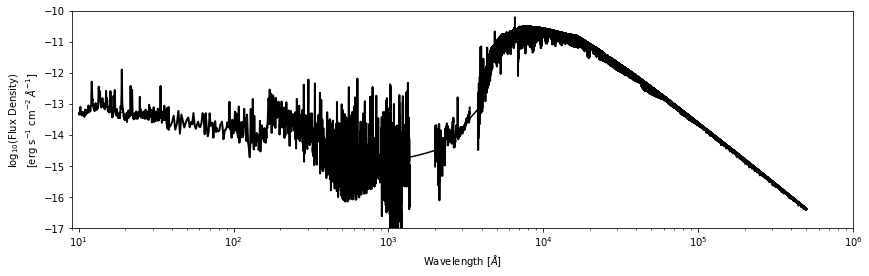

In [27]:
inds = np.array([  0+5,  46-20,  92-25, 138-45, 184, 230+10],dtype=int)
lw = 2
cs = ['k', 'k', 'k', 'k', 'blue', 'purple', 'pink']

tot_wave = np.arange(5,7000,1)*units.AA

fig,ax = plt.subplots(figsize=(14,4), sharex=True, sharey=True)
fig.set_facecolor('w')


## QUIESCENT XMM AND FUSE
xq = (xmm_spectra > 0) & (xmm_wavelength>10)
ax.plot(xmm_wavelength[xq], 
        np.log10(xmm_spectra[xq]*10**-10), c=cs[1],
         lw=lw)

fq = (fuse_spectra>0)
ax.plot(fuse_wavelength[fq], 
        np.log10(fuse_spectra[fq]/2.5), c=cs[1],
         lw=lw)#, label=labels[1])


## DEM
q = ((dem_q[1].data['Wavelength']>xmm_wavelength[xq][-1]) & 
     (dem_q[1].data['Wavelength']<fuse_wavelength[fq][0]))
ax.plot(dem_q[1].data['Wavelength'][q], 
        np.log10(dem_q[1].data['Flux_density'][q]),
        c=cs[2], lw=lw)


## QUIESCENT COS
cq = cos_quiescent['flux_density']>0
ax.plot(cos_quiescent['wavelength_AA'][cq], 
        np.log10(cos_quiescent['flux_density'][cq]),
        c=cs[1], lw=lw)


## IUE
iq = (iue_med_flux > 0) & (iue_med_wave > 2000)
iue_flux = np.log10(iue_med_flux[iq]/1.5)
ax.plot(iue_med_wave[iq], 
        iue_flux, c=cs[1],
         lw=lw)

poly = np.polyfit(np.append(cos_quiescent['wavelength_AA'][cq], iue_med_wave[iq]), 
                  np.append(np.log10(cos_quiescent['flux_density'][cq]), iue_flux), 
                  deg=1)
fit = np.poly1d(poly)
x = np.arange(cos_quiescent['wavelength_AA'][cq][-1], iue_med_wave[iq][0], 0.1)
ax.plot(x, fit(x), 'k')

## QUIESCENT OPTICAL
q = harps_qual==0
harps_med_spectra = np.nanmean(harps_spectra[q],axis=0)
q = harps_med_spectra > 0
qp = phoenix_grid[0][0] > harps_wavelength[q][-1]
harps_flux = np.log10(harps_med_spectra[q][1000:]/5e14)
ax.plot(harps_wavelength[q][1000:], 
        harps_flux,
        c=cs[1], lw=lw)


poly = np.polyfit(np.append(iue_med_wave[iq], harps_wavelength[q][60000:60002]), 
                  np.append(iue_flux, harps_flux[60000:60002]), 
                  deg=1)
fit = np.poly1d(poly)
x = np.arange(iue_med_wave[iq][-2], harps_wavelength[q][0], 0.1)
ax.plot(x, fit(x), 'k')


ax.plot(phoenix_grid[0][0][qp], 
        np.log10(phoenix_grid[1][0][qp]/3e24),
        zorder=1,c=cs[3], lw=lw)


##########################
##### plot logistics #####
##########################

ax.set_xlabel('Wavelength [$\AA$]')
ax.set_ylabel('log$_{10}$(Flux Density)\n[erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]')#,y=1.1)


plt.xlim(9,1e6)

plt.xscale('log')
plt.ylim(-17,-10)